### Solovay-Kitaev Decomposition

In this file, we create our own SK-decomposition code, and we run uL on it to see how many gates it takes.

In [ ]:
# Global helpers
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

# Pauli matrices
X = np.array([[0,1],[1,0]], dtype=complex)
Y = np.array([[0,-1j],[1j,0]], dtype=complex)
Z = np.array([[1,0],[0,-1]], dtype=complex)

# 1) SU(2) projector
def to_su2(M):
    d = M.shape[0]
    sign, logdet = np.linalg.slogdet(M)
    phi = np.angle(sign * np.exp(logdet))
    return M * np.exp(-1j * phi / d)

# 2) random SU(2)
def random_su2():
    A = (np.random.randn(2,2) + 1j*np.random.randn(2,2)) / np.sqrt(2)
    Q, R = np.linalg.qr(A)
    D = np.diag(np.exp(-1j * np.angle(np.diag(R))))
    return to_su2(Q @ D)

# Basic gates and native set
def native_gates():
    H = 1/np.sqrt(2) * np.array([[1,1],[1,-1]], dtype=complex)
    T = np.array([[1,0],[0,np.exp(1j*np.pi/4)]], dtype=complex)
    # return {'H': H, 'T': T, 'Tdg': T.conj().T}
    return {'H': to_su2(H), 'T': to_su2(T), 'Tdg': to_su2(T.conj().T)}

# 3) Closed-form SolveForPhi
def SolveForPhi(theta, tol=1e-12):
    if abs(theta) < tol:
        return 0.0
    return 2 * np.arcsin(np.sqrt(np.sin(theta/4)))

# 4) Axis–angle extraction
def AxisAngle(U, tol=1e-8):
    cos_half = np.real(np.trace(U) / 2)
    theta = 2 * np.arccos(np.clip(cos_half, -1, 1))
    if abs(theta) < tol:
        return 0.0, np.array([0.0, 0.0, 1.0])
    # M = (U - U.conj().T) / (2j * np.sin(theta/2))
    # px = np.real((M[1,0] + M[0,1]) / 2)
    # py = np.imag((M[1,0] - M[0,1]) / 2)
    # pz = np.real((M[0,0] - M[1,1]) / 2)
    (px, py, pz) = (1j/(2*np.sin(theta/2))*np.trace(U @ X), 1j/(2*np.sin(theta/2))*np.trace(U @ Y), 1j/(2*np.sin(theta/2))*np.trace(U @ Z))
    p = np.array([px, py, pz])
    return theta, p / np.linalg.norm(p)

# 5) Arbitrary-axis rotation
def AxisAngleRotation(n, phi):
    nx, ny, nz = np.array(n) / np.linalg.norm(n)
    I = np.eye(2, dtype=complex)
    return np.cos(phi/2) * I - 1j * np.sin(phi/2) * (nx*X + ny*Y + nz*Z)

# 6) Align rotation of Bloch vectors
def AlignRotation(u, v, tol=1e-8):
    # 1) get eigenvalues & eigenvectors of V and U
    evals_V,  evecs_V  = np.linalg.eig(V)
    evals_U,  evecs_U  = np.linalg.eig(U)

    # 2) reorder columns of evecs_V so that evals_V matches evals_U
    #    (they both should be [e^{-iθ/2}, e^{+iθ/2}] up to numerical noise)

    # 3) form W and X
    W = evecs_V      # columns are V’s eigenvectors
    X = evecs_U      # columns are U’s eigenvectors

    # 4) form S

    S = X @ W.conj().T
    return S

# Elementary rotations

def Rz(theta): return np.diag([np.exp(-0.5j*theta), np.exp(0.5j*theta)])

def Rx(theta):
    c, s = np.cos(theta/2), np.sin(theta/2)
    return np.array([[c, -1j*s], [-1j*s, c]], dtype=complex)


def Ry(theta):
    c, s = np.cos(theta/2), np.sin(theta/2)
    return np.array([[c, -s], [s, c]], dtype=complex)

## Single qubit SK-algorithm

### Psuedo code for Solovay-Kitaev algorithm for single qubit gates


function Solovay-Kitaev(Gate = U, depth = n)

    if n == 0:

        return Basic_Approximation(U)

    else:

        Set $U_{n-1}$ = Solovay-Kitaev(U, n-1)

        Set $V, W$ = GC-Decompose($U U^\dagger_{n-1}$)

        Set $V_{n-1}$ = Solovay-Kitaev(V, n-1)

        Set $W_{n-1}$ = Solovay-Kitaev(W, n-1)

        return $U_n = V_{n-1} W_{n-1} V^\dagger_{n-1} W^\dagger_{n-1} U_{n-1}$



In [ ]:
# 8) Simplify sequence (cancel inverses & collapse Ts)
def simplify_sequence(seq):
    """
    Simplify a sequence of H, T, Tdg gates by
      1) cancelling inverse pairs: H H, T Tdg, Tdg T
      2) collapsing runs of T or Tdg to the minimal exponent mod 8
         (so one Tdg stays one Tdg, not seven Ts)
    """
    # --- pass 1: cancel adjacent inverses ---
    stack = []
    for g in seq:
        if stack and (
            (stack[-1]=='H'   and g=='H')   or
            (stack[-1]=='T'   and g=='Tdg') or
            (stack[-1]=='Tdg' and g=='T')
        ):
            stack.pop()
        else:
            stack.append(g)

    # --- pass 2: collect net T-exponent, then emit minimal reps ---
    out = []
    exp = 0
    for g in stack + ['_END_']:
        if g == 'T':
            exp += 1
        elif g == 'Tdg':
            exp -= 1
        else:
            # pick representative r in [-4..+4]
            raw = exp % 8
            # if raw > 4, use the negative equivalent raw-8
            r = raw if raw <= 4 else raw - 8

            if r > 0:
                out.extend(['T'] * r)
            elif r < 0:
                out.extend(['Tdg'] * (-r))
            exp = 0

            if g == 'H':
                out.append('H')

    return out


def unique_sequence(seq):
    seq_as_tuples = [tuple(sub) for sub in seq]
    result = list(dict.fromkeys(seq_as_tuples))
    return [list(tup) for tup in result]

# Generate all sequences of length L

def generate_sequences(G, L):
    gen_seq = [list(p) for p in product(G, repeat=L)]
    simp_seq = [simplify_sequence(i) for i in gen_seq]
    final_seq = unique_sequence(simp_seq)
    final_seq[0] = ['H']
    final_seq += [['T']]
    final_seq += [['Tdg']]
    return final_seq

# Compose and distance
def compose(seq, gate_dict):
    M = np.eye(2, dtype=complex)
    for g in seq:
        M = gate_dict[g] @ M
    return M

def distance(U, V):
    return np.linalg.svd(U - V, compute_uv=False)[0]

# 7) Precompute sequences projected into SU(2)
def precompute_sequences_and_unitaries(G, L0, gate_dict):
    precom = []
    for seq in generate_sequences(G,L0):
        V = np.round(compose(seq, gate_dict), 12)
        precom.append(V)
    return precom



In [29]:
G = ['H','T','Tdg']
L0 = 7
gate_dict = native_gates()

In [30]:
epsilon0_net = precompute_sequences_and_unitaries(G, L0, gate_dict)

In [31]:
def basic_approximation(U):
    epsilon_list = []
    for i in epsilon0_net:
        epsilon_list+=[distance(U, i)]
    return epsilon0_net[epsilon_list.index(min(epsilon_list))]

In [48]:
# def GC_decompose(Delta):
#     theta, n_target = AxisAngle(Delta)
#     phi = SolveForPhi(theta)
#     n_gc = np.array([-np.cos(phi), 0.0, np.sin(phi)])
#     z = np.array([0.0,0.0,1.0])  # just for scratch below
#     # rotation axis that sends n_gc into n_target:
#     rot_axis = np.cross(n_gc, n_target)
#     rot_axis /= np.linalg.norm(rot_axis)
#     # rotation angle between n_gc and n_target:
#     rot_angle = np.arccos(np.dot(n_gc, n_target))
#     S = AxisAngleRotation(rot_axis, rot_angle)
#     Vp = Rx(phi)
#     Wp = Ry(phi)
#     V  = S @ Vp @ S.conj().T
#     W  = S @ Wp @ S.conj().T
#     return to_su2(V), to_su2(W)    

def GC_decompose(Delta):
    Delta = to_su2(Delta)
    theta, U_axis = AxisAngle(Delta)
    phi = SolveForPhi(theta)
    # build raw commutator
    Vp, Wp = Rx(phi), Ry(phi)
    comm_gc = Vp @ Wp @ Vp.conj().T @ Wp.conj().T
    # extract its true axis
    _, gc_axis = AxisAngle(comm_gc)
    # align gc_axis -> U_axis
    rot = np.cross(gc_axis, U_axis)
    if np.linalg.norm(rot) < 1e-12:
        S = np.eye(2, dtype=complex)
    else:
        rot /= np.linalg.norm(rot)
        angle = np.arccos(np.clip(np.dot(gc_axis, U_axis), -1, 1))
        S = AxisAngleRotation(rot, angle)
    V = S @ Vp @ S.conj().T
    W = S @ Wp @ S.conj().T
    return to_su2(V), to_su2(W)

In [49]:
def solovay_kitaevSU2(U, n):
    if n == 0:
        return basic_approximation(U)
    else:
        Un1 = solovay_kitaevSU2(U, n-1)
        V, W = GC_decompose(U @ Un1.conj().T)
        Vn1 = solovay_kitaevSU2(V, n-1)
        Wn1 = solovay_kitaevSU2(W, n-1)
        Un = Vn1 @ Wn1 @ Vn1.conj().T @ Wn1.conj().T @ Un1
        return Un

In [50]:
# helper that calculates gate fidelity
def average_gate_fidelity(U, V):
    d = U.shape[0]
    overlap = np.trace(U.conj().T @ V)
    return (abs(overlap)**2 + d) / (d*(d+1))   # for d=2 gives (|Tr|^2 + 2)/6

In [51]:
list_U = [random_su2() for i in range(500)]

Text(0.5, 1.0, 'depth 0')

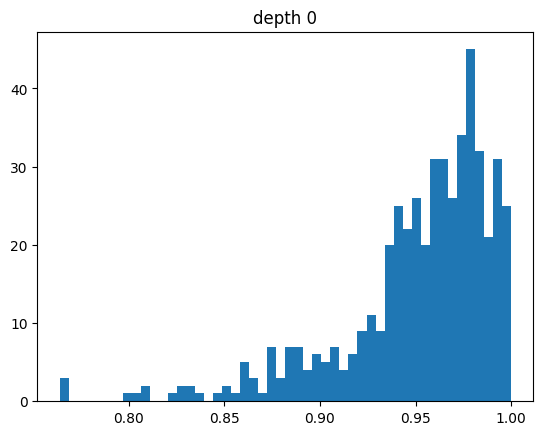

In [52]:
# Depth 0 fidelity histogram
list_F = []
for U in list_U:
    skU = solovay_kitaevSU2(U, 0)
    # dis = distance(U, skU)
    F = average_gate_fidelity(U, skU)
    list_F += [F]
plt.hist(list_F, bins = 50);
plt.title("depth 0")

Text(0.5, 1.0, 'depth 1')

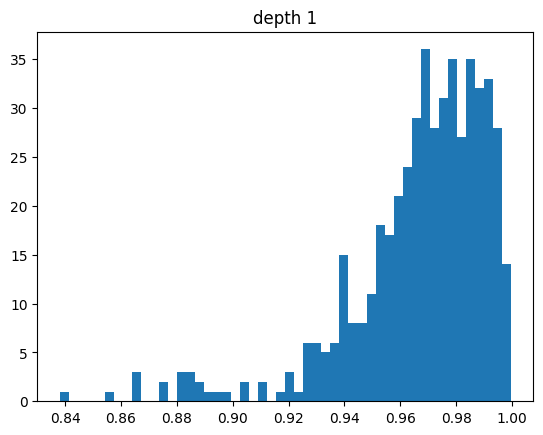

In [53]:
# depth 1 fidelity histogram
list_F = []
for U in list_U:
    skU = solovay_kitaevSU2(U, 1)
    # dis = distance(U, skU)
    F = average_gate_fidelity(U, skU)
    list_F += [F]
plt.hist(list_F, bins = 50);
plt.title("depth 1")

Text(0.5, 1.0, 'depth 2')

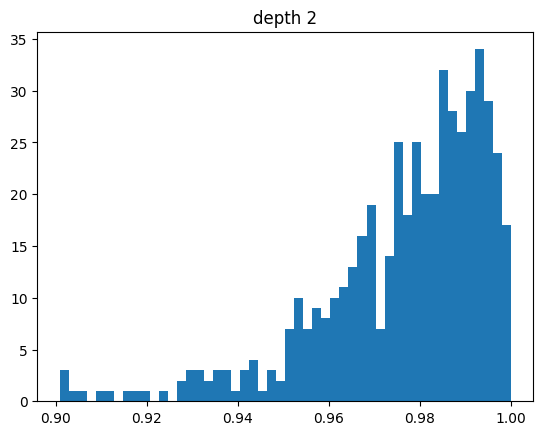

In [54]:
# depth 2 fidelity histogram
list_F = []
for U in list_U:
    skU = solovay_kitaevSU2(U, 2)
    # dis = distance(U, skU)
    F = average_gate_fidelity(U, skU)
    list_F += [F]
plt.hist(list_F, bins = 50);
plt.title("depth 2")

Text(0.5, 1.0, 'depth 4')

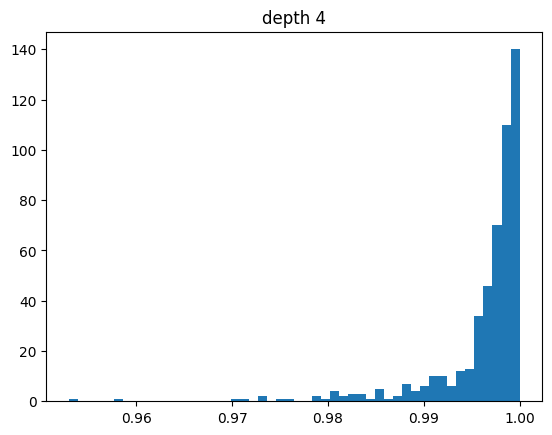

In [55]:
# depth 4 fidelity histogram
list_F = []
for U in list_U:
    skU = solovay_kitaevSU2(U, 4)
    # dis = distance(U, skU)
    F = average_gate_fidelity(U, skU)
    list_F += [F]
plt.hist(list_F, bins = 50);
plt.title("depth 4")

In [ ]:
def euler_decompose(U):
    """
    Given a 2×2 unitary U, return (α, β, γ) so that
    U ≈ Rz(γ) · Rx(β) · Rz(α).
    """
    A = U[0,0]
    B = U[1,1]
    C = U[1,0]
    # 1) β from magnitude of A
    beta = 2*np.arccos(np.clip(np.abs(A), -1, 1))
    # 2) α+γ from phase of U[1,1]
    alpha_plus_gamma = 2*np.angle(B)
    # 3) α−γ from phase of U[1,0] (plus π/2)
    alpha_minus_gamma = 2*(np.angle(C) + np.pi/2)
    # Solve
    alpha = (alpha_plus_gamma + alpha_minus_gamma)/2
    gamma = (alpha_plus_gamma - alpha_minus_gamma)/2
    # Normalize to [0,2π)
    return alpha % (2*np.pi), beta % (2*np.pi), gamma % (2*np.pi)

In [ ]:
# helper that invert a gate-sequence
def invert_sequence(seq):
    """
    Given a gate‐name list like ['T','H','Tdg'], return the reversed,
    daggered version: ['T','H','Tdg'] → ['T','H','Tdg']⁻¹ = ['T','H','Tdg']^op
    with H†=H, T†=Tdg, Tdg†=T.
    """
    inv = []
    for g in reversed(seq):
        if   g == 'T':   inv.append('Tdg')
        elif g == 'Tdg': inv.append('T')
        else:            inv.append(g)     # H† = H
    return inv


## Multi-qubit SK-algorithm

### Psuedo code for Solovay-Kitaev algorithm for multi-qubit gates


function Solovay-Kitaev(Gate = U, depth = n)

    if n == 0:

        return Basic_Approximation(U)

    else:

        Set $U_{n-1}$ = Solovay-Kitaev(U, n-1)

        Set $V, W$ = GC-Approx-Decompose($U U^\dagger_{n-1}$)

        Set $V_{n-1}$ = Solovay-Kitaev(V, n-1)

        Set $W_{n-1}$ = Solovay-Kitaev(W, n-1)

        return $U_n = V_{n-1} W_{n-1} V^\dagger_{n-1} W^\dagger_{n-1} U_{n-1}$



This algorithm scales poorly with high d because the basic approximation enumerate through a huge net. I don't think it is practical to implement it for uL. Maybe do this later as a fun exercise.

In [ ]:
# global helpers for SU(d)

def to_sud(M):
    d = M.shape[0]
    φ = np.angle(np.linalg.det(M))
    return M * np.exp(-1j*φ/d)


def random_sud(d):
    A = (np.random.randn(d,d) + 1j*np.random.randn(d,d))/np.sqrt(2)
    Q, R = np.linalg.qr(A)
    D = np.diag(np.exp(-1j * np.angle(np.diag(R))))
    return to_sud(Q @ D)


def generate_net(d, epsilon0, L0):
    return list_net

def basic_approximation_sud(U):
    return U0



In [ ]:
def log_to_su(M):
    return H # hermision traceless, dxd

def pick_two_level_subspace(Delta):
    return (i, j) # find the off-diagonal entry of H with largest magnitude

def restrict_to_subspace(Delta, i, j)
    return Delta2 # 2x2 submatrix of Delta

